**Segmentation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import zipfile
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow
import glob

In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.15.0
/device:GPU:0
Num GPU Available:  1


# Check Data

In [ ]:
def list_deepest_child_folders(folder_path):
    """
    Recursively lists the deepest child folders (those without any subfolders) with their full paths from the parent folder.
    """
    # Initialize a list to store the deepest child folders
    deepest_child_folders = []

    # Get the list of items (files and folders) in the parent folder
    items = os.listdir(folder_path)

    # Iterate over each item
    for item in items:
        # Create the full path of the item
        item_path = os.path.join(folder_path, item)

        # Check if the item is a folder
        if os.path.isdir(item_path):
            # Recursively check if the folder has any subfolders
            subfolders = [f for f in os.listdir(item_path) if os.path.isdir(os.path.join(item_path, f))]
            if not subfolders:
                # If the folder does not have any subfolders, add it to the list of deepest child folders
                deepest_child_folders.append(item_path)
            else:
                # If the folder has subfolders, recursively add the deepest child folders to the list
                deepest_child_folders.extend(list_deepest_child_folders(item_path))

    # Return the list of deepest child folders
    return deepest_child_folders

# Specify the parent folder path
drive_folder_path = '/content/drive/MyDrive/Cityscapes_dataset'

# Get the list of deepest child folders with their full paths from the parent folder
data_paths = list_deepest_child_folders(drive_folder_path)

# Print the list of deepest child folders
for path in data_paths:
    print(path)

/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_test
/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_train
/content/drive/MyDrive/Cityscapes_dataset/images_prepped_test
/content/drive/MyDrive/Cityscapes_dataset/images_prepped_train


In [ ]:
# Initialize an empty list to store the results
results = []

# Iterate through each folder path
for folder_path in data_paths:
  # Check if the folder exists
  if os.path.exists(folder_path):
      # Count the number of files in the folder that have a common image extension (e.g., .jpg, .png, .jpeg)
      num_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
      # Append the folder path and the number of images to the results list
      results.append({'Folder': folder_path, 'Total Images': num_images})
  else:
      print(f"Folder {folder_path} does not exist.")

# Convert the results list to a pandas DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
df

,Folder,Total Images
0,/content/drive/MyDrive/Cityscapes_dataset/anno...,101
1,/content/drive/MyDrive/Cityscapes_dataset/anno...,367
2,/content/drive/MyDrive/Cityscapes_dataset/imag...,101
3,/content/drive/MyDrive/Cityscapes_dataset/imag...,398


#View Data

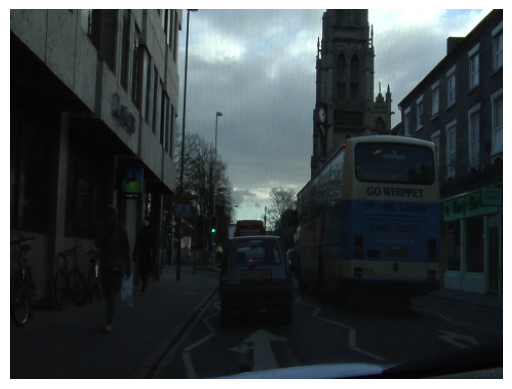

In [ ]:
# Load the PNG image
img = mpimg.imread('/content/drive/MyDrive/Cityscapes_dataset/images_prepped_train/0001TP_006810.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

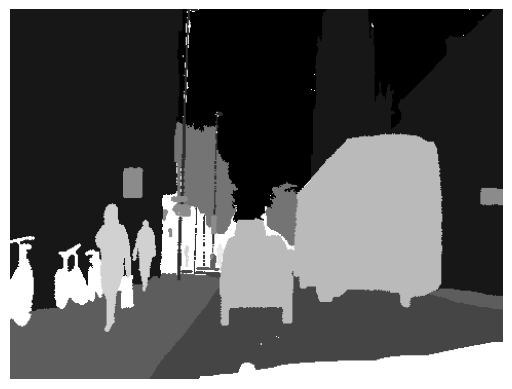

In [ ]:
annotation_img = mpimg.imread('/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_train/0001TP_006810.png')

# Display the annotation image
plt.imshow(annotation_img, cmap='gray')  # Set cmap='gray' jika gambar anotasi berwarna abu-abu
plt.axis('off')
plt.show()

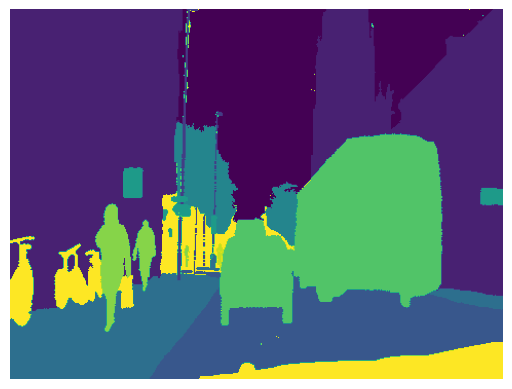

In [ ]:
# Load the annotation image
annotation_img = mpimg.imread('/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_train/0001TP_006810.png')

# Display the annotation image with a color map
plt.imshow(annotation_img)
plt.axis('off')
plt.show()

Unique Labels: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.03137255 0.03529412 0.03921569 0.04313726]


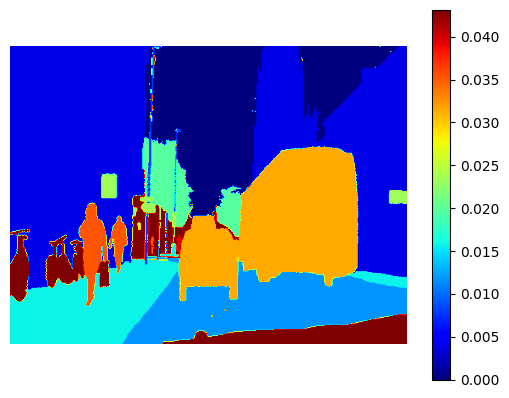

In [ ]:
# Load the annotation image
annotation_img = plt.imread('/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_train/0001TP_006810.png')

# Print unique pixel values (labels)
unique_labels = np.unique(annotation_img)
print("Unique Labels:", unique_labels)

# Visualize the annotation image with labels
plt.imshow(annotation_img, cmap='jet')  # You can use any colormap
plt.colorbar()  # Add color bar to show label values
plt.axis('off')
plt.show()

In [ ]:
# Load the annotation image
annotation_img = plt.imread('/content/drive/MyDrive/Cityscapes_dataset/annotations_prepped_train/0001TP_006810.png')

# Get unique pixel values (labels)
unique_labels = np.unique(annotation_img)

# Print unique labels
print("Unique Labels:", unique_labels)

Unique Labels: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.03137255 0.03529412 0.03921569 0.04313726]


#Import Image and Annotations

In [ ]:
IMAGES_TRAIN_PATH = "/content/drive/MyDrive/Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train/"
IMAGES_TEST_PATH = "/content/drive/MyDrive/Dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test/"

ANNOT_TRAIN_PATH = "/content/drive/MyDrive/Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/"
ANNOT_TEST_PATH = "/content/drive/MyDrive/Dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test/"

images_train_filename = os.listdir(IMAGES_TRAIN_PATH)
images_test_filename = os.listdir(IMAGES_TEST_PATH)

In [ ]:
images_train_filename

['0006R0_f02820.png',
 '0016E5_00840.png',
 '0016E5_01830.png',
 '0016E5_06630.png',
 '0006R0_f01470.png',
 '0016E5_07770(1).png',
 '0016E5_00901.png',
 '0006R0_f01380.png',
 '0016E5_06720.png',
 '0016E5_00600.png',
 '0016E5_07110.png',
 '0006R0_f02790.png',
 '0006R0_f02640.png',
 '0016E5_04350.png',
 '0016E5_07770.png',
 '0016E5_07830(1).png',
 '0016E5_07230.png',
 '0016E5_00450.png',
 '0016E5_00930.png',
 '0006R0_f02850.png',
 '0016E5_01050.png',
 '0016E5_07830(2).png',
 '0006R0_f02670.png',
 '0016E5_01110.png',
 '0006R0_f03450.png',
 '0016E5_07830.png',
 '0016E5_01140.png',
 '0006R0_f00960.png',
 '0016E5_04410.png',
 '0006R0_f02370.png',
 '0016E5_06660.png',
 '0016E5_05160.png',
 '0016E5_02340.png',
 '0016E5_04650.png',
 '0016E5_04440.png',
 '0006R0_f03150.png',
 '0016E5_00990.png',
 '0016E5_07770(2).png',
 '0016E5_04860.png',
 '0016E5_06870.png',
 '0016E5_01680.png',
 '0016E5_07500.png',
 '0001TP_008400.png',
 '0016E5_07440.png',
 '0016E5_04710.png',
 '0006R0_f02760.png',
 '0006R0_

In [ ]:
def preprocess_data(filename, dir_x, dir_y, SHAPE = 416):
  # cv2.imread(path, flag). Using 0 to read image in grayscale mode
  image_x = cv2.imread(dir_x + filename, 0)
  image_y = cv2.imread(dir_y + filename, 0)

  if(image_y is not None):

    #reshaping image to 224x224
    image_x = cv2.resize(image_x, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
    image_y = cv2.resize(image_y, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
    return image_x, image_y

In [ ]:
IMAGES_TRAIN_ARR = []
ANNOTATIONS_TRAIN_ARR = []
IMAGES_TEST_ARR = []
ANNOTATIONS_TEST_ARR = []

for filename in images_train_filename:
  print(filename)
  if os.path.exists(ANNOT_TRAIN_PATH+filename):
    img_x, img_y = preprocess_data(filename, IMAGES_TRAIN_PATH, ANNOT_TRAIN_PATH)
    IMAGES_TRAIN_ARR.append(img_x)
    ANNOTATIONS_TRAIN_ARR.append(img_y)

for filename in images_test_filename:
  if os.path.exists(ANNOT_TEST_PATH+filename):
    img_x, img_y = preprocess_data(filename,IMAGES_TEST_PATH, ANNOT_TEST_PATH)
    IMAGES_TEST_ARR.append(img_x)
    ANNOTATIONS_TEST_ARR.append(img_y)

IMAGES_TRAIN_ARR = np.array(IMAGES_TRAIN_ARR)
ANNOTATIONS_TRAIN_ARR = np.array(ANNOTATIONS_TRAIN_ARR)
IMAGES_TEST_ARR = np.array(IMAGES_TEST_ARR)
ANNOTATIONS_TEST_ARR = np.array(ANNOTATIONS_TEST_ARR)

0006R0_f02820.png
0016E5_00840.png
0016E5_01830.png
0016E5_06630.png
0006R0_f01470.png
0016E5_07770(1).png
0016E5_00901.png
0006R0_f01380.png
0016E5_06720.png
0016E5_00600.png
0016E5_07110.png
0006R0_f02790.png
0006R0_f02640.png
0016E5_04350.png
0016E5_07770.png
0016E5_07830(1).png
0016E5_07230.png
0016E5_00450.png
0016E5_00930.png
0006R0_f02850.png
0016E5_01050.png
0016E5_07830(2).png
0006R0_f02670.png
0016E5_01110.png
0006R0_f03450.png
0016E5_07830.png
0016E5_01140.png
0006R0_f00960.png
0016E5_04410.png
0006R0_f02370.png
0016E5_06660.png
0016E5_05160.png
0016E5_02340.png
0016E5_04650.png
0016E5_04440.png
0006R0_f03150.png
0016E5_00990.png
0016E5_07770(2).png
0016E5_04860.png
0016E5_06870.png
0016E5_01680.png
0016E5_07500.png
0001TP_008400.png
0016E5_07440.png
0016E5_04710.png
0006R0_f02760.png
0006R0_f01860.png
0006R0_f03570.png
0006R0_f03810(1).png
0016E5_06240.png
0016E5_07890.png
0016E5_02070.png
0016E5_04470.png
0001TP_008010.png
0016E5_05730.png
0001TP_007020.png
0016E5_05130.pn

In [ ]:
print('IMAGES TRAIN ARRAY SHAPE:', IMAGES_TRAIN_ARR.shape)
print('ANNOTA TRAIN ARRAY SHAPE:', ANNOTATIONS_TRAIN_ARR.shape)
print('IMAGES TEST ARRAY SHAPE:', IMAGES_TEST_ARR.shape)
print('ANNOTA TEST ARRAY SHAPE:', ANNOTATIONS_TEST_ARR.shape)

IMAGES TRAIN ARRAY SHAPE: (367, 416, 416)
ANNOTA TRAIN ARRAY SHAPE: (367, 416, 416)
IMAGES TEST ARRAY SHAPE: (101, 416, 416)
ANNOTA TEST ARRAY SHAPE: (101, 416, 416)


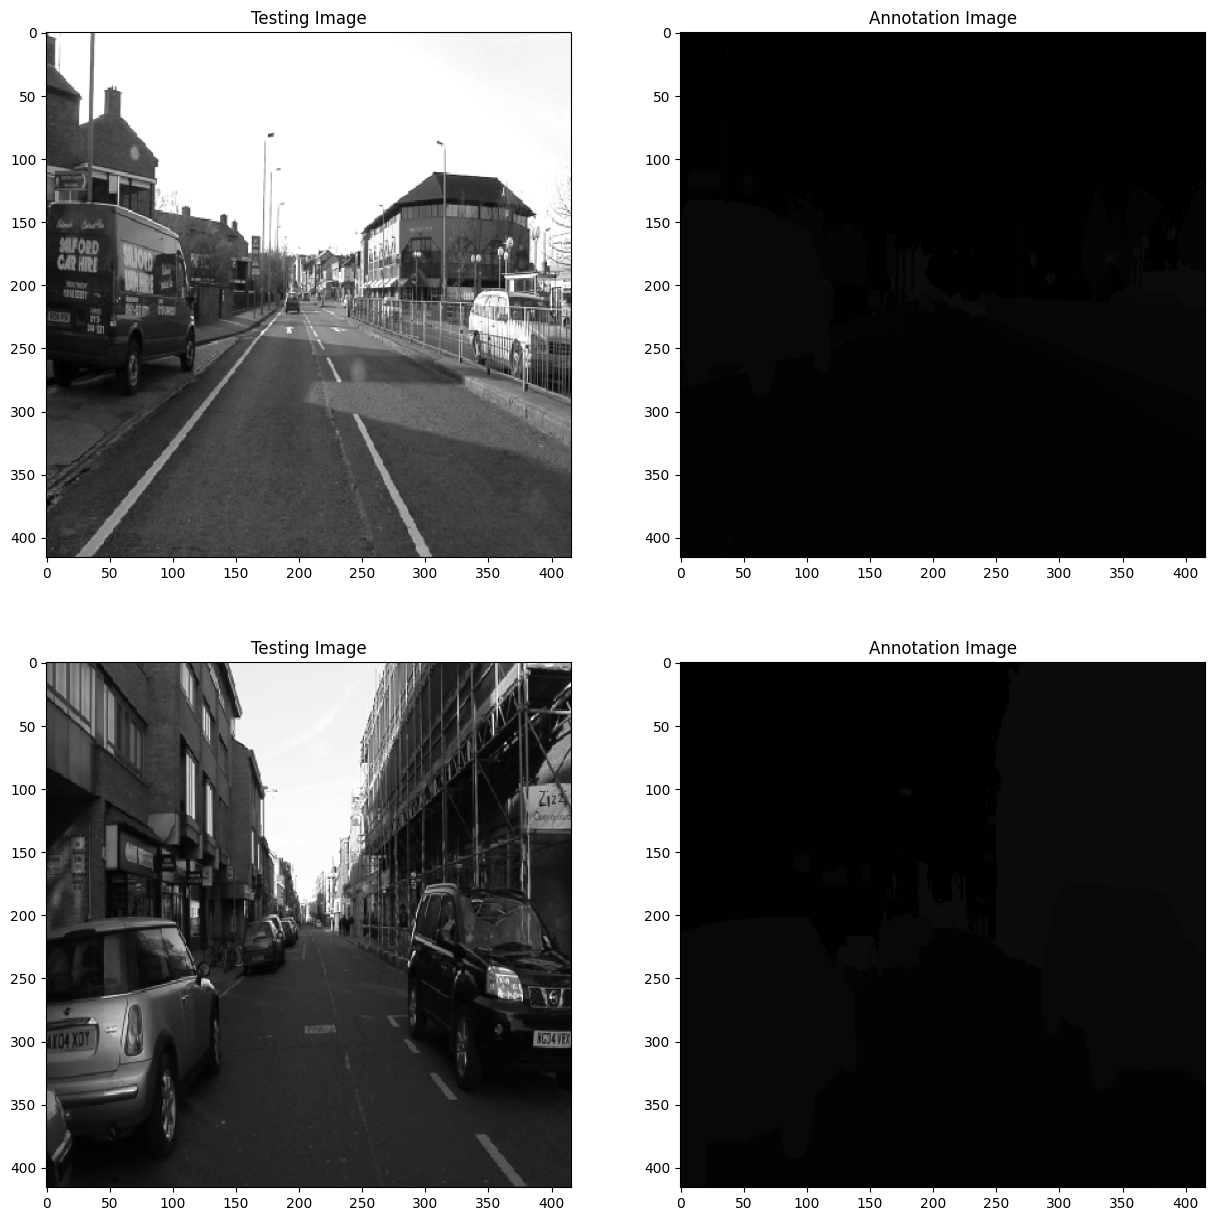

In [ ]:
# plot training images
plt.figure(figsize=(15,15))
for i in range(1, 4, 2):
  plt.subplot(2, 2, i)
  plt.imshow(IMAGES_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Testing Image')
  plt.subplot(2, 2, i+1)
  plt.imshow(ANNOTATIONS_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Annotation Image')
plt.show()

In [ ]:
# function to get unique values
def get_class(image_y):
  array = image_y.ravel()
  return np.unique(array)

In [ ]:
# get information from the dataset
print('image prepped train shape:', IMAGES_TRAIN_ARR.shape)
print('annotations prepped train shape:', ANNOTATIONS_TRAIN_ARR.shape)
print('image prepped test shape:', IMAGES_TEST_ARR.shape)
print('annotations prepped test shape:', ANNOTATIONS_TEST_ARR.shape)
print('data train:', len(IMAGES_TRAIN_ARR))
print('data test:', len(IMAGES_TEST_ARR))

print('\n')
print("unique value of 'annotation'")
print("kind of class :", get_class(ANNOTATIONS_TRAIN_ARR[2]))
print("number of classes:", len(get_class(ANNOTATIONS_TRAIN_ARR[2])))

print('\n')
print("unique value of 'image'")
print("kind of class :\n", get_class(IMAGES_TRAIN_ARR[2]))
print("number of classes:", len(get_class(IMAGES_TRAIN_ARR[2])))

image prepped train shape: (367, 416, 416)
annotations prepped train shape: (367, 416, 416)
image prepped test shape: (101, 416, 416)
annotations prepped test shape: (101, 416, 416)
data train: 367
data test: 101


unique value of 'annotation'
kind of class : [ 0  1  2  3  4  5  6  7  8  9 10 11]
number of classes: 12


unique value of 'image'
kind of class :
 [  6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 

In [ ]:
#Normalize Data
# Data train
x = np.expand_dims(IMAGES_TRAIN_ARR, axis=3)
train_x_norm = normalize(x.reshape(x.shape[0],-1), axis=1).reshape(x.shape)
train_y_norm = np.expand_dims(ANNOTATIONS_TRAIN_ARR, axis=3)

# # Data test
y = np.expand_dims(IMAGES_TEST_ARR, axis=3)
test_x_norm = normalize(y.reshape(y.shape[0],-1), axis=1).reshape(y.shape)
test_y_norm = np.expand_dims(ANNOTATIONS_TEST_ARR, axis=3)

In [ ]:
# after normalization data
print('Train images shape:', train_x_norm.shape)
print('Train annots shape:', train_y_norm.shape)
print('Test images shape:', test_x_norm.shape)
print('Test annots shape:', test_y_norm.shape)

Train images shape: (367, 416, 416, 1)
Train annots shape: (367, 416, 416, 1)
Test images shape: (101, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)


In [ ]:
#Split Dataset
# split train data -> train & validation data
train_x, val_x, train_y, val_y = train_test_split(train_x_norm, train_y_norm, test_size=0.1, random_state=14)
print('Train images shape:', train_x.shape)
print('Valid images shape:', val_x.shape)
print('Train annots shape:', train_y.shape)
print('Valid images shape:', val_y.shape)

# test = test_norm
test_x, test_y = test_x_norm, test_y_norm
print('Test annots shape:', test_x.shape)
print('Test images shape:', test_y.shape)

Train images shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Train annots shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)
Test images shape: (101, 416, 416, 1)


In [ ]:
# num of classes
n_classes = 12

# One Hot Encoding Train Data Annotation
train_y_cat = keras.utils.to_categorical(train_y, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = keras.utils.to_categorical(val_y, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

In [ ]:
from keras.utils import to_categorical

# num of classes
n_classes = 12

# Function to check and fix label values
def check_and_fix_labels(labels, n_classes):
    labels_fixed = np.clip(labels, 0, n_classes - 1)  # Clip values to be within the valid range
    return labels_fixed

# Fixing labels for train, val, and test data
train_y_fixed = check_and_fix_labels(train_y, n_classes)
val_y_fixed = check_and_fix_labels(val_y, n_classes)
test_y_fixed = check_and_fix_labels(test_y_norm, n_classes)

# One Hot Encoding Train Data Annotation
train_y_cat = to_categorical(train_y_fixed, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = to_categorical(val_y_fixed, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = to_categorical(test_y_fixed, num_classes=n_classes)

In [ ]:
# after encode annotations dataset
print('Class values in the dataset are:', get_class(train_y[0]))
print('Train images shape', train_x.shape)
print('Train labels shape', train_y_cat.shape)

print('\nClass values in the dataset are:', get_class(val_y[0]))
print('Validation images shape', val_x.shape)
print('Validation labels shape', val_y_cat.shape)

print('\nClass values in the dataset are:', get_class(test_y[0]))
print('Test images shape', test_x.shape)
print('Test labels shape', test_y_cat.shape)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Train images shape (330, 416, 416, 1)
Train labels shape (330, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  6  7  8  9 10 11]
Validation images shape (37, 416, 416, 1)
Validation labels shape (37, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test images shape (101, 416, 416, 1)
Test labels shape (101, 416, 416, 12)


In [ ]:
def UNet(image_size, ch_in=1, ch_out=3):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # The Contraction Path
  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # The Bottleneck Path
  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) #Dropout sifatnya opsional

  # The Expansion Path
  # Blok 6
  up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(dropout5))
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Blok 7
  up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Blok 8
  up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Blok 9
  up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  # jumlah unit = jumlah class = pada kasus ini 2
  unit = 12
  conv10 = Conv2D(unit, 1, activation='relu')(conv9)
  conv10 = Conv2D(unit, 1, activation='softmax')(conv10)

  outputs = conv10

  model = Model(inputs, outputs)

  return model

In [ ]:
model = UNet(image_size=(416, 416))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 416, 416, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 64)         640       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 416, 416, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 208, 208, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

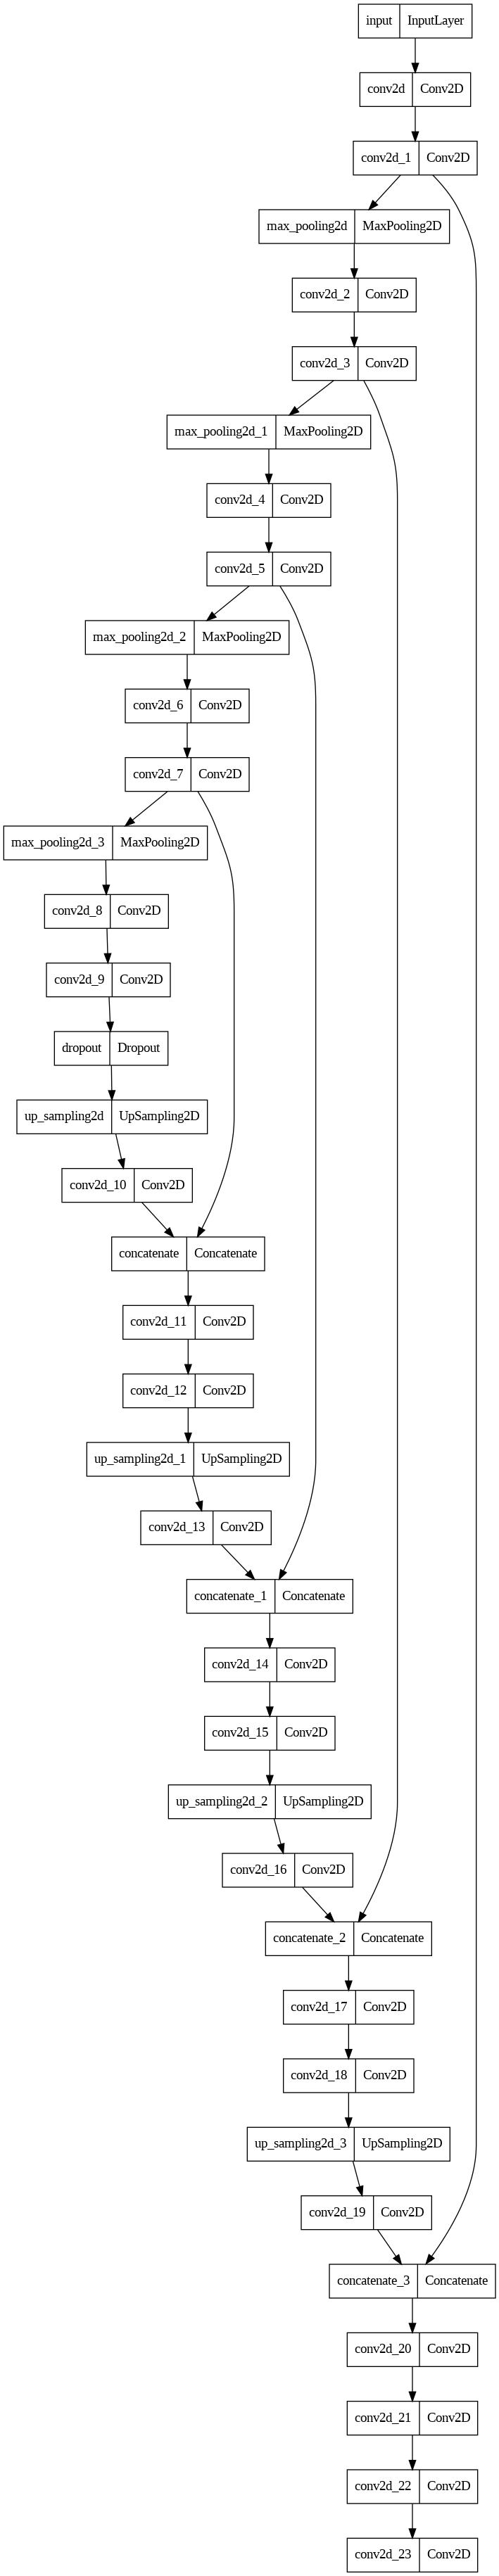

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

In [ ]:
# from re import VERBOSE
# Train training ke-
iter = 3
batch_size = 3
epoch = 100

# Checkpoint
MODEL_DIRECTORY = '/content/drive/MyDrive/project3/HASIL/MODEL/'
MODEL_NAME = f'my_model-{iter}.h5'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.0001, verbose = 1, restore_best_weights = True)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 2.1089 - accuracy: 0.2359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 56s 285ms/step - loss: 2.1089 - accuracy: 0.2359 - val_loss: 1.9909 - val_accuracy: 0.3249
Epoch 2/100
110/110 [==============================] - 28s 253ms/step - loss: 1.9191 - accuracy: 0.3064 - val_loss: 1.9024 - val_accuracy: 0.3249
Epoch 3/100
110/110 [==============================] - 34s 305ms/step - loss: 1.8513 - accuracy: 0.3358 - val_loss: 1.8808 - val_accuracy: 0.3269
Epoch 4/100
110/110 [==============================] - 33s 302ms/step - loss: 1.6427 - accuracy: 0.4547 - val_loss: 1.5431 - val_accuracy: 0.4945
Epoch 5/100
110/110 [==============================] - 28s 255ms/step - loss: 1.6745 - accuracy: 0.4412 - val_loss: 1.6583 - val_accuracy: 0.4365
Epoch 6/100
110/110 [==============================] - 33s 304ms/step - loss: 1.5310 - accuracy: 0.4926 - val_loss: 1.5268 - val_accuracy: 0.4945
Epoch 7/100
110/110 [==============================] - 33s 300ms/step - loss: 1.4773 - accuracy: 0.5006 - val_loss: 1.4949 - val_accurac

Text(0.5, 1.0, 'Training and Validation Loss-(3)')

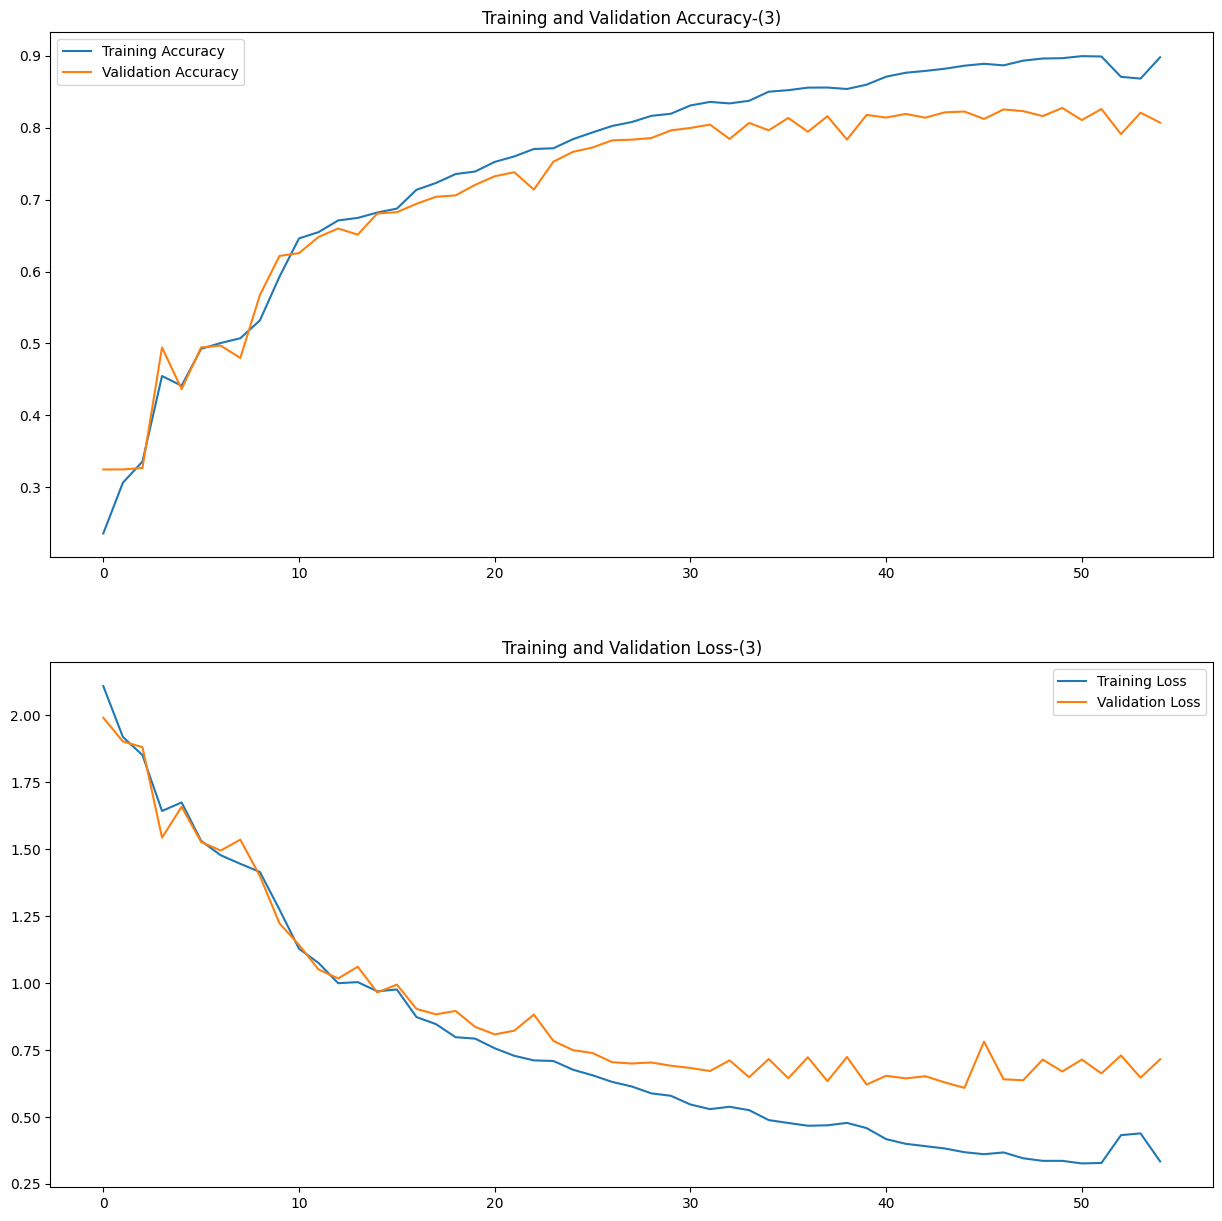

In [ ]:
# Plot training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy-({iter})')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')

plt.title(f'Training and Validation Loss-({iter})')


In [ ]:
# saving the model manually

MODEL_DIRECTORY = '/content/drive/MyDrive/project3/HASIL/MODEL/'
MODEL_NAME = f'my_model_-{iter}.h5'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)

model.save(MODEL_DIRECTORY)
print('Saved trained model at %s ' % MODEL_PATH)

Saved trained model at /content/drive/MyDrive/project3/HASIL/MODEL/my_model_-3.h5 


In [ ]:
# View the models stored in the model directory
MODEL_DIRECTORY = '/content/drive/MyDrive/project3/HASIL/MODEL/'
MODEL_LISTDIR = os.listdir(MODEL_DIRECTORY)
MODEL_LISTDIR

['my_model-3.h5',
 'variables',
 'assets',
 'saved_model.pb',
 'fingerprint.pb',
 'keras_metadata.pb']

In [ ]:
# load the model and weight
LOADMODEL_PATH = os.path.join(MODEL_DIRECTORY)
load_model = keras.models.load_model('/content/drive/MyDrive/project3/HASIL/MODEL/my_model-3.h5')
print('Loaded trained model at %s' %LOADMODEL_PATH)

Loaded trained model at /content/drive/MyDrive/project3/HASIL/MODEL/


In [ ]:
# Evaluate the model with the same amount of validation data
# test_x_norm[:37], test_y_cat[:37]
score = load_model.evaluate(test_x[:10], test_y_cat[:10], verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7542707324028015
Test accuracy: 0.7977868318557739


In [ ]:
n_classes=12
# give color annota img
def give_color_to_annota_img(annota_img):
  random_colors = []

  for i in range(5000):
    random.seed(i)
    randColor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    random_colors.append(randColor)

  annota_img_zeros = np.zeros((416, 416, 3))
  for j in range(n_classes):
    annota_img_zeros[:, :, 0] += ((annota_img[:, :, 0] == j)*(random_colors[j][0])).astype('uint8')
    annota_img_zeros[:, :, 1] += ((annota_img[:, :, 0] == j)*(random_colors[j][1])).astype('uint8')
    annota_img_zeros[:, :, 2] += ((annota_img[:, :, 0] == j)*(random_colors[j][2])).astype('uint8')

  annota_img_zeros = cv2.cvtColor(np.array(annota_img_zeros, dtype=np.uint8), cv2.COLOR_BGR2RGB)
  return annota_img_zeros

# plot grayscale img
def plot_img(input_img, title='', iter=0):
  N_ch = input_img.shape[2]
  if N_ch == 1:
    plt.imshow(input_img[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title(title + f' {[iter]}')
  elif N_ch == 3:
    plt.imshow(input_img)
    plt.title(title + f' {[iter]}')
  else:
    print('error image')
    return
  # set the spacing between subplots
  plt.subplots_adjust(bottom=0.1, top=0.5)

# invert encoding (to_categorical) to original data
def invert_from_cat(img_cat):
  inverted = tf.keras.backend.argmax(img_cat)
  inverted_1dims = np.expand_dims(inverted, axis=2)
  return inverted_1dims

# preprocessing to predict
def prepare(filename):
  IMAGE_CHANNEL = 1 # or 3
  IMG_SIZE = 416
  new_array = cv2.resize(filename, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

# IoU of Each Class
def get_IoU_of_class(annota_img, pred_img):
  from keras.metrics import MeanIoU
  val,sum3 = 0,0
  IoU_arr = []
  IoU_keras = MeanIoU(num_classes=n_classes)
  IoU_keras.update_state(annota_img, pred_img)
  values = np.array(IoU_keras.get_weights()).reshape(n_classes, n_classes)
  print("IoU of Each Class:")
  for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    for k in range(n_classes):
        if k != i:
            sum2 = values[k, i] + sum2
        else:
            continue
    sum3 = sum1 + sum2
    IoU_arr.append(val/sum3)
    print(f"IoU Class {i}: {val/sum3*100:.2f}%")
  print(f"Mean IoU: {IoU_keras.result().numpy()*100:.2f}%")

  plt.figure(figsize=(9, 10))
  plt.bar(np.arange(0, len(IoU_arr)), IoU_arr)
  plt.xticks(np.arange(0, len(IoU_arr)))
  plt.ylabel("IoU")
  plt.xlabel("Class")
  plt.title("IoU of Each Class")

# Function to predict
# input: 1 image from test_x & test_y_cat
def predict_annotation(img_x, img_y, iter=0):
  # inverse from normalize data
  grayscale_img = img_x*255*255

  # predict image
  prediction = load_model.predict([prepare(img_x)])
  prediction_reshape = prediction.reshape((416, 416, 12)) # test_y_cat[0].shape

  # invert predict from categorical
  pred_invert = invert_from_cat(prediction_reshape)
  annota_img = invert_from_cat(img_y)

  # give color to pred_invert image
  colored_annota_img = give_color_to_annota_img(annota_img)
  colored_pred = give_color_to_annota_img(pred_invert)

  # masked image
  grayscale_img3ch = np.zeros((416, 416, 3))
  grayscale_img3ch = np.expand_dims(grayscale_img3ch, axis=3)

  grayscale_img3ch[:,:,0] += grayscale_img
  grayscale_img3ch[:,:,1] += grayscale_img
  grayscale_img3ch[:,:,2] += grayscale_img
  grayscale_img3ch2 = grayscale_img3ch.reshape(grayscale_img3ch.shape[0],grayscale_img3ch.shape[1], grayscale_img3ch.shape[2])
  masked_image = cv2.addWeighted(np.array(grayscale_img3ch2, dtype=np.uint8), 0.5, np.array(colored_pred, dtype=np.uint8), 0.5, 0)

  # plot image
  img_arr = [grayscale_img, annota_img, colored_annota_img, pred_invert, colored_pred, masked_image]
  title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']

  num_imgs = len(img_arr)
  num_cols = 2
  num_rows = int(np.ceil(num_imgs / num_cols))

  plt.figure(figsize=(num_cols * 8, num_rows * 5)) # adjust figure size dynamically
  for i in range(len(img_arr)):
      plt.subplot(num_rows, num_cols, i+1)
      plot_img(img_arr[i], title_arr[i], iter)

  # IoU of Each Class
  get_IoU_of_class(annota_img, pred_invert)

  # plot figure
  plt.tight_layout()
  plt.show()


1/1 [==============================] - 0s 26ms/step
IoU of Each Class:
IoU Class 0: 94.36%
IoU Class 1: 51.25%
IoU Class 2: 0.00%
IoU Class 3: 93.05%
IoU Class 4: 70.76%
IoU Class 5: 64.19%
IoU Class 6: 0.00%
IoU Class 7: 3.72%
IoU Class 8: 19.56%
IoU Class 9: 5.66%
IoU Class 10: 26.79%
IoU Class 11: 11.78%
Mean IoU: 36.76%


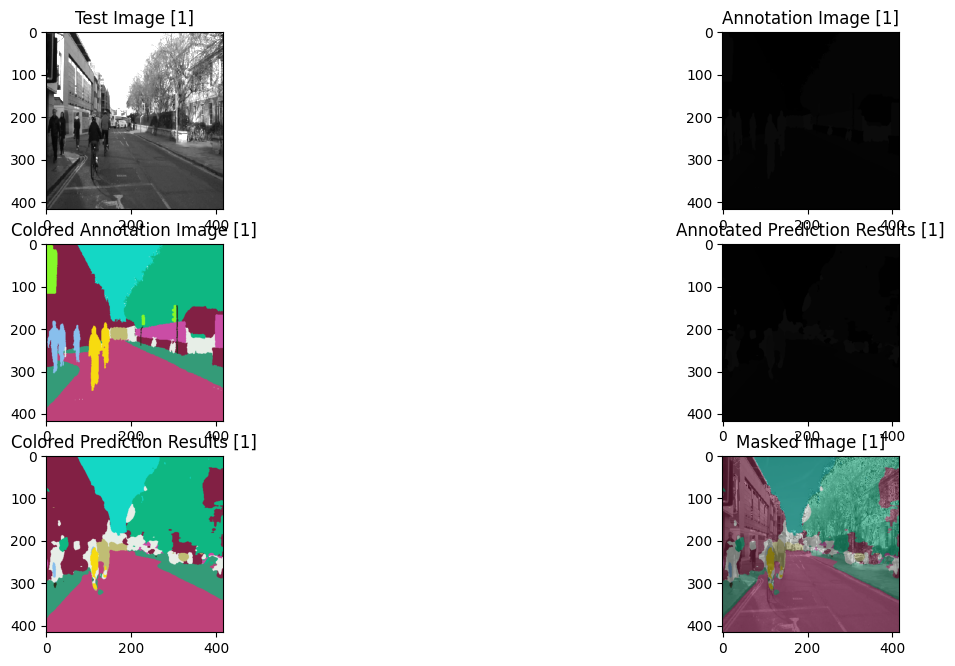

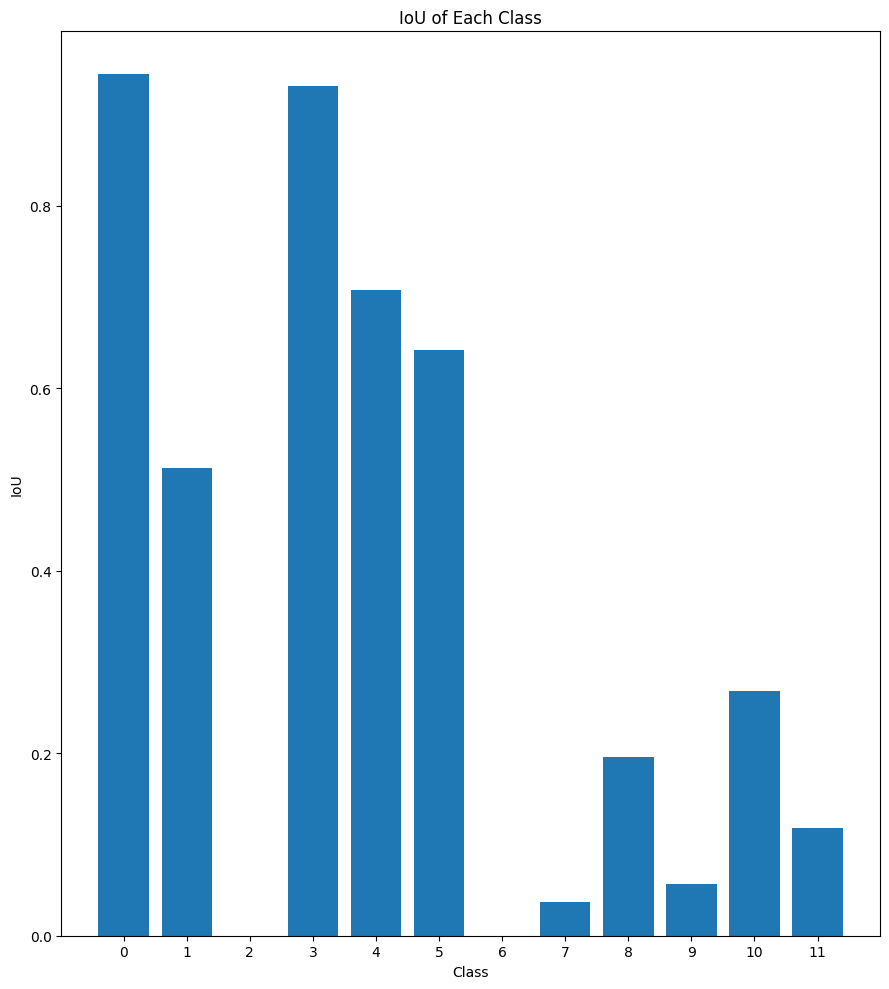

In [ ]:
# testing the function
predict_annotation(test_x[0], test_y_cat[0], 1)

1/1 [==============================] - 0s 29ms/step
IoU of Each Class:
IoU Class 0: 94.13%
IoU Class 1: 62.33%
IoU Class 2: 0.00%
IoU Class 3: 94.99%
IoU Class 4: 85.88%
IoU Class 5: 49.77%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 61.87%
IoU Class 9: 1.96%
IoU Class 10: 7.90%
IoU Class 11: 5.97%
Mean IoU: 38.73%


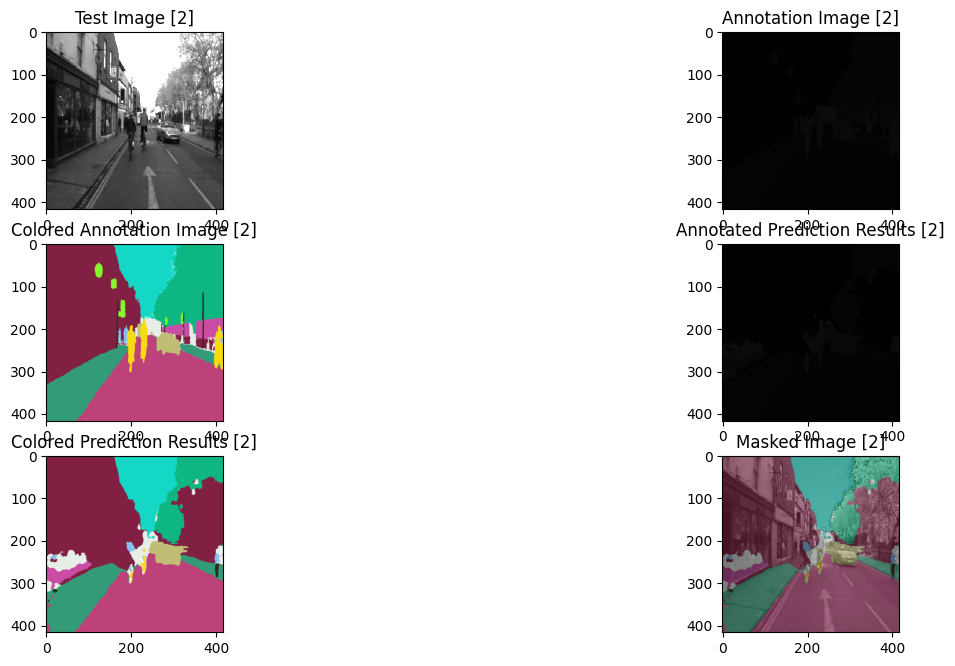

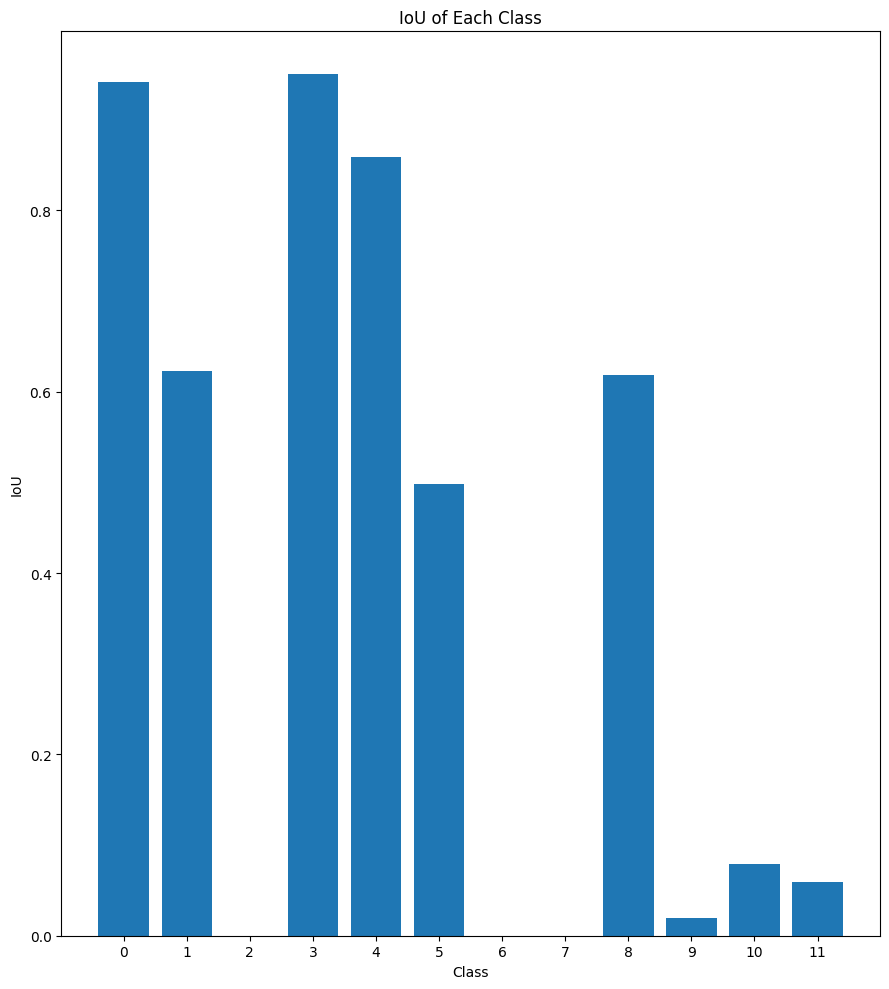

In [ ]:
# testing the function
predict_annotation(test_x[1], test_y_cat[1], 2)

1/1 [==============================] - 0s 26ms/step
IoU of Each Class:
IoU Class 0: 90.96%
IoU Class 1: 56.84%
IoU Class 2: 0.00%
IoU Class 3: 92.89%
IoU Class 4: 68.75%
IoU Class 5: 68.59%
IoU Class 6: 0.00%
IoU Class 7: 2.40%
IoU Class 8: 13.66%
IoU Class 9: 0.04%
IoU Class 10: 33.07%
IoU Class 11: 11.45%
Mean IoU: 36.55%


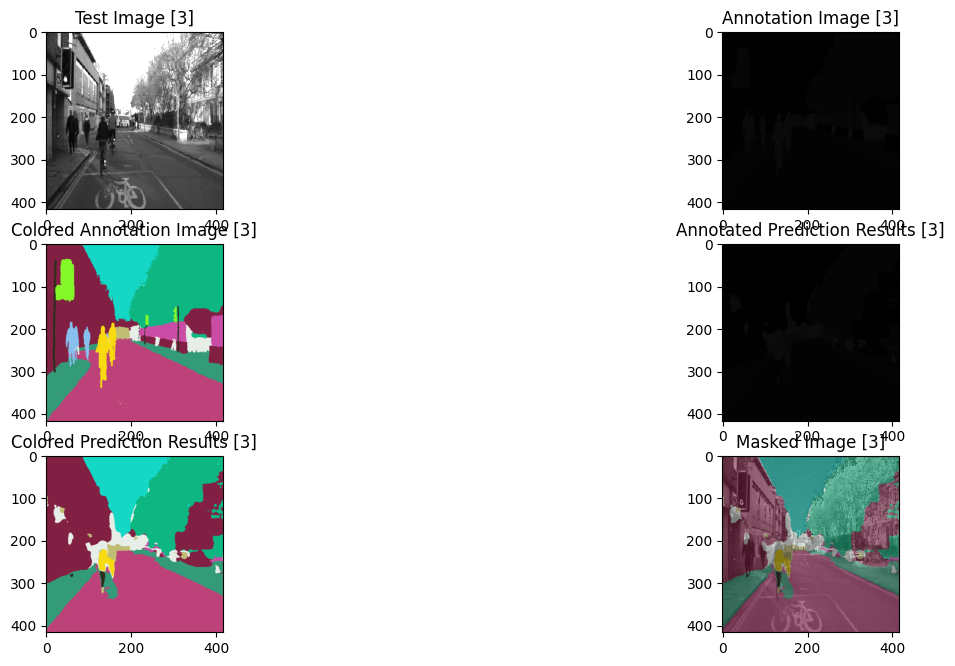

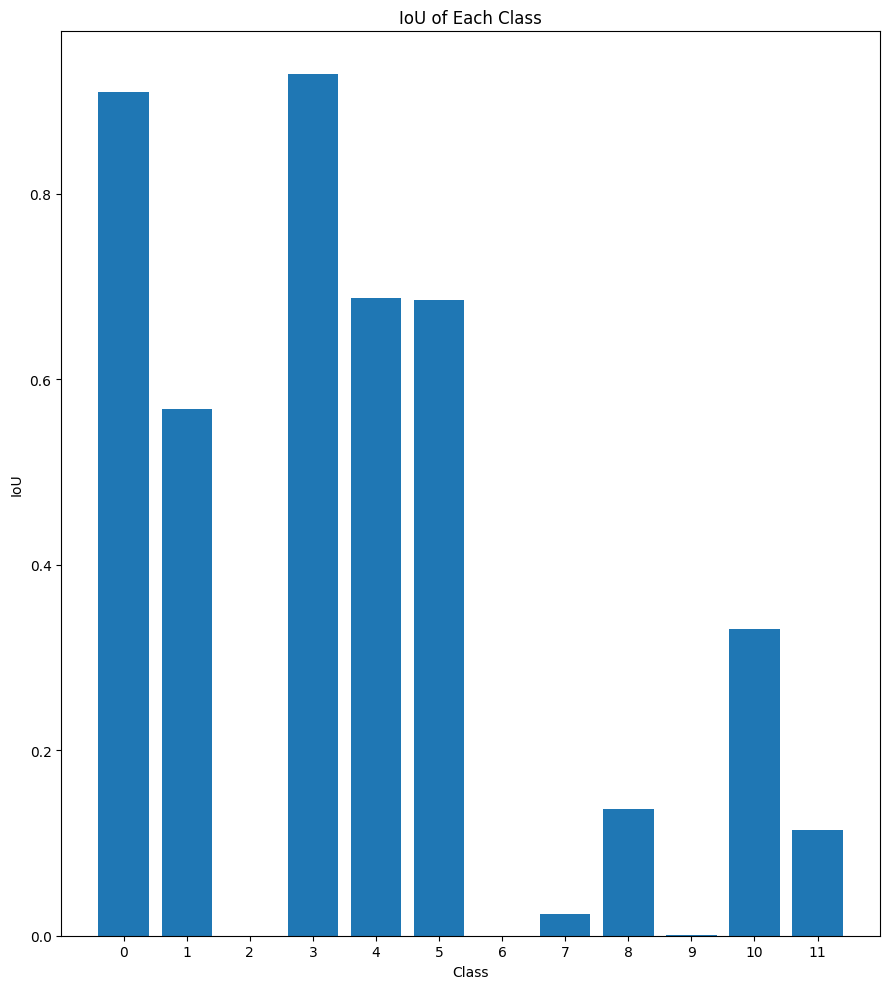

In [ ]:
# testing the function
predict_annotation(test_x[2], test_y_cat[2], 3)